In [0]:
pip install prophet

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
pip install tensorflow

Python interpreter will be restarted.
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Not uninstalling markupsafe at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-32f87f77-74ff-4e97-9aff-d2a60823130d
    Can't uninstall 'MarkupSafe'. No files were found to uninstall.
Python interpreter will be restarted.


In [0]:
pip install xgboost

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# IMPORTING DATA ANALYSIS AND VISUALIZATION LIBRARIES
import pandas as pd
from datetime import datetime
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SPARK LIBRARIES 
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType
from pyspark.sql.types import DoubleType
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, StandardScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# MODELING 
# from prophet import Prophet
import logging
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

# WARNINGS AND LOGISTICS 
#   Make sure we do not get line breaks when doing show on wide dataframes
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))
import warnings
warnings.filterwarnings("ignore")
#   disable informational messages from prophet
logging.getLogger('py4j').setLevel(logging.ERROR)

# Set the display options to show all columns
pd.set_option('display.max_columns', None)


In [0]:
%run ./Snowflake_Connection

In [0]:
sfdt = SnowflakeDataTool()

In [0]:
# LOAD IN THE TWO CLUSTERING MODELS // CONVERT THEM TO PANDAS 

df_sel_brand = spark.table('ltf_db.modeling_01_sc_sel_brand_grouping')


In [0]:

from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler

train_start_year = 2019
train_stop_year = 2021
test_start_year = 2022
test_stop_year = 2022 

# Define the function to fit a model to each cluster
def fit_model(df_458_00):
    # Convert the dataframe to a dense vector
    assembler = VectorAssembler(inputCols=["WEEK", "YEAR", "CUSTOMER_ID", "MATERIAL_ID"], outputCol="features")
    data = assembler.transform(df_458_00).select("DATE", "WEEKLY_DEMAND")
    
    # Rename the columns to fit Prophet requirements
    data = df_458_00.withColumnRenamed("DATE", "ds").withColumnRenamed("WEEKLY_DEMAND", "y")

    # Split the data into training and testing sets
    train_df = data.filter((year("ds") >= train_start_year) & (year("ds") <= train_stop_year))
    test_df = data.filter((year("ds") >= test_start_year) & (year("ds") <= test_stop_year))

    # Train the model
    m = Prophet()
    m.fit(train_df)

    # Make predictions on the testing data
    future = m.make_future_dataframe(periods=365, include_history=False)
    forecast = m.predict(future)

    # Evaluate the model
    test_results = test_df.join(forecast, on="ds", how="left")
    rmse = test_results.selectExpr("sqrt(avg((yhat - y) * (yhat - y))) as rmse").collect()[0]["rmse"]
    
    # Return the model and its accuracy
    return (m, rmse)


#TRAIN AND TEST SPLIT FUNCTION

In [0]:
from pyspark.sql.functions import year

def train_test_split(df_sel_brand, train_start_year, train_stop_year, test_start_year, test_stop_year):
    """
    Splits a PySpark DataFrame into training and test sets based on start and stop years.

    Args:
        df (pyspark.sql.DataFrame): The PySpark DataFrame to split.
        train_start_year (int): The start year for the training set.
        train_stop_year (int): The stop year for the training set.
        test_start_year (int): The start year for the test set.
        test_stop_year (int): The stop year for the test set.

    Returns:
        tuple: A tuple containing the filtered training and test sets as PySpark DataFrames.
    """
    # Filter the DataFrame to include only rows between start and stop years
    train_df = df_sel_brand.filter((year("TS_DATE") >= train_start_year) & (year("TS_DATE") <= train_stop_year) & (year("TS_DATE") != 2022))
    test_df = df_sel_brand.filter((year("TS_DATE") >= test_start_year) & (year("TS_DATE") <= test_stop_year))

    return train_df, test_df

train_df, test_df = train_test_split(df_sel_brand, 2019, 2021, 2022, 2022)

In [0]:

train_df = train_df.withColumnRenamed("TS_DATE", "ds").withColumnRenamed("ORDERED_WEEKLY_SUM", "y")
test_df = test_df.withColumnRenamed("TS_DATE", "ds").withColumnRenamed("ORDERED_WEEKLY_SUM", "y")


In [0]:
train_df = train_df.withColumn('y', col('y').cast('double'))
test_df = test_df.withColumn('y', col('y').cast('double'))

# train_df.write.mode('overwrite').format("delta").option("overwriteSchema", "true").mode('overwrite').saveAsTable('ltf_db.train_sc_sel_brand_grouping')
# test_df.write.mode('overwrite').format("delta").option("overwriteSchema", "true").mode('overwrite').saveAsTable('ltf_db.test_sc_sel_brand_grouping')

In [0]:
display(test_df)

ds,CUSTOMER_ID,MATERIAL_ID,SUPER_CHANNEL_DEFINITION,SEL_CLUSTER,BRAND_DESC,y
2022-09-09,0500276754,000000000000156843,VALUE,SEL-4,POWERADE,1.0
2022-09-09,0500276754,000000000000156843,VALUE,SEL-4,POWERADE,1.0
2022-09-09,0500276754,000000000000156843,VALUE,SEL-4,POWERADE,1.0
2022-09-09,0500276754,000000000000156843,VALUE,SEL-4,POWERADE,1.0
2022-09-09,0500276754,000000000000156843,VALUE,SEL-4,POWERADE,1.0
2022-09-09,0500276754,000000000000156843,VALUE,SEL-4,POWERADE,1.0
2022-09-09,0500276754,000000000000156843,VALUE,SEL-4,POWERADE,1.0
2022-09-09,0500276754,000000000000156843,VALUE,SEL-4,POWERADE,1.0
2022-09-09,0500276754,000000000000156843,VALUE,SEL-4,POWERADE,1.0
2022-09-09,0500276754,000000000000156843,VALUE,SEL-4,POWERADE,1.0


In [0]:
from pyspark.sql.functions import col, sum, date_format, collect_list, size, to_date, concat, lit

# Set minimum time series length threshold
min_ts_length = 52

# Filter out null values and select the required columns
train_df = train_df.filter(col("ds").isNotNull() & col("y").isNotNull()) \
                   .select("ds", "y", "SUPER_CHANNEL_DEFINITION", "SEL_CLUSTER", "BRAND_DESC")

# Extract year and week information from the ds column
grouped_df = train_df.groupBy("SUPER_CHANNEL_DEFINITION", "SEL_CLUSTER", "BRAND_DESC", date_format("ds", "yyyy-Www").alias("week")) \
                     .agg(sum("y").alias("y"))

# Convert the week column back to a date format
grouped_df = grouped_df.withColumn("week", to_date(concat(col("week"), lit("-1")), "yyyy-'W'ww-u"))

# Filter out groups with time series shorter than min_ts_length
grouped_df = grouped_df.groupBy("SUPER_CHANNEL_DEFINITION", "SEL_CLUSTER", "BRAND_DESC") \
                       .agg(collect_list("week").alias("weeks"), collect_list("y").alias("y")) \
                       .filter(size("weeks") >= min_ts_length) \
                       .select("SUPER_CHANNEL_DEFINITION", "SEL_CLUSTER", "BRAND_DESC", "weeks", "y")

# Loop through each group and create a Prophet model
for row in grouped_df.rdd.collect():
    super_channel = row["SUPER_CHANNEL_DEFINITION"]
    sel_cluster = row["SEL_CLUSTER"]
    brand = row["BRAND_DESC"]
    weeks = row["weeks"]
    y = row["y"]
    
    try:
        # Create a Prophet model
        prophet_model = Prophet(weekly_seasonality=True, yearly_seasonality=True, seasonality_mode="multiplicative")
        
        # Create a pandas DataFrame with the time series data
        ts_df = pd.DataFrame({"ds": weeks, "y": y})
        
        # Fit the Prophet model to the time series data
        prophet_model.fit(ts_df)
        
        # Make future predictions with the Prophet model
        future_df = prophet_model.make_future_dataframe(periods=52, freq="W")
        forecast_df = prophet_model.predict(future_df)
        
        # Print the forecast results
        print(f"Forecast results for group ({super_channel}, {sel_cluster}, {brand}):")
        print(forecast_df[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail())
        
        # Plot the forecast
        fig = prophet_model.plot(forecast_df)
        fig.suptitle(f"Forecast for group ({super_channel}, {sel_cluster}, {brand})")
        fig.savefig(f"{super_channel}_{sel_cluster}_{brand}_forecast.png")
        
    except Exception as e:
        print(f"Failed to create model for group ({super_channel}, {sel_cluster}, {brand}): {e}")



In [0]:
display(grouped_df)

SUPER_CHANNEL_DEFINITION,SEL_CLUSTER,BRAND_DESC,weeks,y


In [0]:
from pyspark.sql.functions import col, weekofyear, sum
import pandas as pd

# Filter out null values and select the required columns
train_df = train_df.filter(col("ds").isNotNull() & col("y").isNotNull()).select("ds", "y", "SUPER_CHANNEL_DEFINITION", "SEL_CLUSTER", "BRAND_DESC")

# Group and aggregate the data based on the required columns and weekly frequency
grouped_df = train_df.groupBy("SUPER_CHANNEL_DEFINITION", "SEL_CLUSTER", "BRAND_DESC", weekofyear("ds").alias("week")).agg(sum("y").alias("y"))

# Pivot the data to create a time series with each week as a column
pivoted_df = grouped_df.groupBy("SUPER_CHANNEL_DEFINITION", "SEL_CLUSTER", "BRAND_DESC").pivot("week").sum("y")

# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = pivoted_df.toPandas()
pandas_df

In [0]:
from pyspark.sql.functions import col, sum, date_format
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

conf = SparkConf().setAppName("myApp")\
                 .setMaster("local[*]")\
                 .set("spark.sql.legacy.timeParserPolicy", "LEGACY")

spark = SparkSession.builder.config(conf=conf).getOrCreate()


# Filter out null values and select the required columns
train_df = train_df.filter(col("ds").isNotNull() & col("y").isNotNull()) \
                   .select("ds", "y", "SUPER_CHANNEL_DEFINITION", "SEL_CLUSTER", "BRAND_DESC")

# Extract year and week information from the ds column
grouped_df = train_df.groupBy("SUPER_CHANNEL_DEFINITION", "SEL_CLUSTER", "BRAND_DESC", 
                              ((date_format("ds", "yyyy") - 2019) * 52 + date_format("ds", "w")).alias("week")) \
                     .agg(sum("y").alias("y"))

# Pivot the data to create a time series with each week as a column
pivoted_df = grouped_df.groupBy("SUPER_CHANNEL_DEFINITION", "SEL_CLUSTER", "BRAND_DESC") \
                       .pivot("week") \
                       .sum("y")

# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = pivoted_df.toPandas()
pandas_df


,SUPER_CHANNEL_DEFINITION,SEL_CLUSTER,BRAND_DESC,1.0,2.0,3.0,4.0,5.0,6.0,7.0,...,147.0,148.0,149.0,150.0,151.0,152.0,153.0,154.0,155.0,156.0
0,FULL SERVICE,SEL-2,DIET DR PEPPER-CS,67.529,678.444,560.238,695.333,604.697,580.803,371.009,...,688.036,1306.65,755.76,596.495,918.091,353.089,698.712,326.744,657.525,284.785
1,SUPER MARKET,SEL-2,DIET DR PEPPER-CS,71281.000,36098.000,75059.000,28399.000,112849.000,65837.000,39876.000,...,134787.000,219600.00,179221.00,294403.000,339834.000,162097.000,118871.000,198095.000,241731.000,213544.000
2,ON PREMISE,SEL-2,GLACEAU VWTR ZERO-KO,3026.000,51.000,2207.000,25.000,3830.000,4254.000,3535.000,...,26046.000,914.00,6962.00,4695.000,4476.000,3222.000,1231.000,1034.000,17156.000,6323.000
3,HYPER,SEL-1,DIET DR PEPPER-CS,83928.000,116561.000,120917.000,135258.000,160777.000,118406.000,158587.000,...,222488.000,208397.00,169438.00,213830.000,279359.000,238277.000,190688.000,261551.000,194793.000,206017.000
4,SUPER MARKET,SEL-2,GLACEAU VITAMINWATER-KO,662.000,2237.000,1511.000,1021.000,1871.000,578.000,1135.000,...,21718.000,41831.00,15582.00,28847.000,35856.000,10665.000,53276.000,6549.000,7102.000,8592.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,HYPER,SEL-1,FUZE-KO,54.000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1444,ON PREMISE,SEL-4,CAFFEINE FREE BARQ'S,NaN,3.000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1445,MASS,SEL-1,BODYARMOR EDGE-KO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1446,MASS,SEL-1,CAFFE' MONSTER-KO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:

import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# Define functions for each of the chosen algorithms
def prophet_model(df):
    model = prophet.Prophet(weekly_seasonality=True, holidays=holidays)
    model.fit(df)
    future = model.make_future_dataframe(periods=52, freq='W')
    forecast = model.predict(future)
    return forecast

def arima_model(df):
    model = sm.tsa.ARIMA(df, order=(1, 1, 1))
    result = model.fit()
    forecast = result.forecast(steps=52)
    return forecast

def lstm_model(df):
    # Define and train an LSTM model using TensorFlow or Keras
    return forecast

def xgboost_model(df):
    model = xgb.XGBRegressor()
    model.fit(df.drop("y", axis=1), df["y"])
    forecast = model.predict(df.drop("y", axis=1))
    return forecast

def sarima_model(df):
    model = sm.tsa.statespace.SARIMAX(df, order=(1, 1, 1), seasonal_order=(0, 1, 1, 52))
    result = model.fit()
    forecast = result.forecast(steps=52)
    return forecast

def random_forest_model(df):
    model = RandomForestRegressor()
    model.fit(df.drop("y", axis=1), df["y"])
    forecast = model.predict(df.drop("y", axis=1))
    return forecast

# Loop through each group of the Pandas DataFrame and apply the chosen algorithm
results = {}
for group, df in pandas_df.groupby(["SUPER_CHANNEL_DEFINITION", "SEL_CLUSTER", "BRAND_DESC"]):
    try:
        forecast = prophet_model(df)
        results[group] = forecast
    except:
        print(f"Failed to create Prophet model for group {group}")
    try:
        forecast = arima_model(df)
        results[group] = forecast
    except:
        print(f"Failed to create ARIMA model for group {group}")
    try:
        forecast = lstm_model(df)
        results[group] = forecast
    except:
        print(f"Failed to create LSTM model for group {group}")
    try:
        forecast = xgboost_model(df)
        results[group] = forecast
    except:
        print(f"Failed to create XGBoost model for group {group}")
    try:
        forecast = sarima_model(df)
        results[group] = forecast
    except:
        print(f"Failed to create SARIMA model for group {group}")


Failed to create Prophet model for group ('ALL OTHER', 'SEL-1', 'AHA-KO')
Failed to create ARIMA model for group ('ALL OTHER', 'SEL-1', 'AHA-KO')
Failed to create LSTM model for group ('ALL OTHER', 'SEL-1', 'AHA-KO')
Failed to create XGBoost model for group ('ALL OTHER', 'SEL-1', 'AHA-KO')
Failed to create SARIMA model for group ('ALL OTHER', 'SEL-1', 'AHA-KO')
Failed to create Prophet model for group ('ALL OTHER', 'SEL-1', 'ALOE GLOE')
Failed to create ARIMA model for group ('ALL OTHER', 'SEL-1', 'ALOE GLOE')
Failed to create LSTM model for group ('ALL OTHER', 'SEL-1', 'ALOE GLOE')
Failed to create XGBoost model for group ('ALL OTHER', 'SEL-1', 'ALOE GLOE')
Failed to create SARIMA model for group ('ALL OTHER', 'SEL-1', 'ALOE GLOE')
Failed to create Prophet model for group ('ALL OTHER', 'SEL-1', 'ANCILLARY ITEMS')
Failed to create ARIMA model for group ('ALL OTHER', 'SEL-1', 'ANCILLARY ITEMS')
Failed to create LSTM model for group ('ALL OTHER', 'SEL-1', 'ANCILLARY ITEMS')
Failed to cre

In [0]:
from pyspark.sql.functions import concat_ws, sum, when, collect_list
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col

# Convert the "y" column to a double type
train_df = train_df.withColumn("y", train_df["y"].cast(DoubleType()))

# Replace non-numeric values with null
train_df = train_df.withColumn("y", when(col("y").cast("string").rlike("\\d+(\\.\\d+)?"), col("y")).otherwise(None))

# Filter out any rows where "y" is null
train_df = train_df.filter(col("y").isNotNull())

# Group the data and aggregate the "ds" and "y" columns
grouped_df = train_df.groupBy("SUPER_CHANNEL_DEFINITION", "SEL_CLUSTER", "BRAND_DESC")
agg_df = grouped_df.agg(concat_ws(",", collect_list("ds")).alias("ds"), sum("y").alias("y"))



In [0]:
display(agg_df)

In [0]:
# Get the count of rows for each group
group_counts = grouped_df.count()

# Print the number of groups and the number of rows for each group
print(f"There are {group_counts.count()} unique grouping combinations.")
for row in group_counts.collect():
    super_channel = row["SUPER_CHANNEL_DEFINITION"]
    sel_cluster = row["SEL_CLUSTER"]
    brand_desc = row["BRAND_DESC"]
    num_rows = row["count"]
    print(f"Group {super_channel}, {sel_cluster}, {brand_desc} contains {num_rows} rows.")


There are 1448 unique grouping combinations.
Group SUPER MARKET, SEL-2, DIET DR PEPPER-CS contains 767073 rows.
Group DRUG, SEL-4, FULL THROTTLE contains 6 rows.
Group ON PREMISE, SEL-2, GLACEAU VWTR ZERO-KO contains 80542 rows.
Group ON PREMISE, SEL-4, DASANI contains 437005 rows.
Group HYPER, SEL-1, DIET DR PEPPER-CS contains 3342262 rows.
Group ON PREMISE, SEL-1, COCA-COLA contains 626269 rows.
Group SUPER MARKET, SEL-3, BARQ'S contains 358247 rows.
Group CONVENIENCE RETAIL, SEL-3, GLACEAU VWTR ZERO-KO contains 80873 rows.
Group VALUE, SEL-3, FANTA contains 11148 rows.
Group HYPER, SEL-2, MINUTE MAID contains 234787 rows.
Group ON PREMISE, SEL-2, DUNKIN' contains 22998 rows.
Group CONVENIENCE RETAIL, SEL-4, TOPO CHICO-KO contains 73848 rows.
Group DRUG, SEL-1, FANTA contains 112546 rows.
Group SUPER MARKET, SEL-1, MONSTER-KO contains 2588046 rows.
Group CONVENIENCE RETAIL, SEL-4, MCCAFE contains 6401 rows.
Group HYPER, SEL-3, COCA-COLA contains 2678408 rows.
Group ALL OTHER, SEL-1, 

In [0]:
# Get the count of rows for each group
group_counts = grouped_df.count()

# Print the number of groups and the number of rows for each group
print(f"There are {group_counts.count()} unique grouping combinations.")
num_small_groups = 0
for row in group_counts.collect():
    super_channel = row["SUPER_CHANNEL_DEFINITION"]
    sel_cluster = row["SEL_CLUSTER"]
    brand_desc = row["BRAND_DESC"]
    num_rows = row["count"]
    if num_rows < 105:
        print(f"Group {super_channel}, {sel_cluster}, {brand_desc} contains only {num_rows} rows.")
        num_small_groups += 1
print(f"There are {num_small_groups} groups with less than 105 rows.")


There are 1448 unique grouping combinations.
Group HYPER, SEL-4, MELLO YELLO contains only 3 rows.
Group ALL OTHER, SEL-3, PEACE-KO contains only 42 rows.
Group VALUE, SEL-1, CAFFE' MONSTER-KO contains only 6 rows.
Group ALL OTHER, SEL-3, SEAGRAMS-KO contains only 18 rows.
Group ON PREMISE, SEL-3, MCCAFE contains only 36 rows.
Group ALL OTHER, SEL-3, MICRODOSE UNBRANDED contains only 20 rows.
Group SUPER MARKET, SEL-3, YUP-KO contains only 60 rows.
Group SUPER MARKET, SEL-2, CAFFE' MONSTER-KO contains only 32 rows.
Group DRUG, SEL-4, FULL THROTTLE contains only 6 rows.
Group SUPER MARKET, SEL-4, MINUTE MAID SPARKLING contains only 19 rows.
Group SUPER MARKET, SEL-4, FUZE-KO contains only 1 rows.
Group ALL OTHER, SEL-3, HONEST-KO contains only 38 rows.
Group ON PREMISE, SEL-2, SOUTHERN SUN contains only 68 rows.
Group ALL OTHER, SEL-4, FUZE-KO contains only 10 rows.
Group VALUE, SEL-4, MONSTER contains only 14 rows.
Group ALL OTHER, SEL-1, ZICO-KO contains only 47 rows.
Group ALL OTHER,

In [0]:
agg_df_pandas = agg_df.toPandas()


In [0]:
# Group the agg_df_pandas DataFrame by the "group" column and count the number of non-NaN rows
non_na_counts = agg_df_pandas.groupby(["SUPER_CHANNEL_DEFINITION", "SEL_CLUSTER", "BRAND_DESC"]).apply(lambda x: x["y"].count())

# Filter the groups with less than 2 non-NaN rows
groups_with_few_observations = non_na_counts[non_na_counts < 2].index

# Print the groups with less than 2 non-NaN rows
if len(groups_with_few_observations) > 0:
    print("The following groups have less than 2 non-NaN rows:")
    for group in groups_with_few_observations:
        print((group))

The following groups have less than 2 non-NaN rows:
('SEL-2', 'BODYARMOR EDGE-KO')
('SEL-2', 'MONSTER')
('SEL-2', 'PIBB')
('SEL-2', 'SOUTHERN SUN')
('SEL-2', 'TAB')
('SEL-3', 'BODYARMOR SPORTWATER-KO')
('SEL-3', 'GLACEAU FRUITWATER')
('SEL-3', 'MINUTE MAID SPARKLING')
('SEL-3', 'MUTANT')
('SEL-3', 'SOUTHERN SUN')
('SEL-3', 'UNSPECIFIED CROSS-LIC. PRODUCTS')
('SEL-4', 'MUTANT')
('SEL-4', 'MUTANT-CS')
('SEL-4', 'PIBB')
('SEL-4', 'UNSPECIFIED CROSS-LIC. PRODUCTS')


In [0]:
from prophet import Prophet
import traceback

# Define a function to fit a Prophet model and make a forecast for a group
def fit_and_forecast(group_df):
    # Create a Prophet model and fit it to the data
    model = Prophet()
    model.fit(group_df)
    
    # Make a forecast for the next 365 days
    future = model.make_future_dataframe(periods=52, freq='W')
    forecast = model.predict(future)
    
    # Return the forecast
    return forecast[['ds', 'yhat']]

# Loop over the groups in agg_df_pandas, fit a Prophet model for each group, and make a forecast
forecasts = []
failed_df_groups = {}
for group, group_df in agg_df_pandas.groupby(["SUPER_CHANNEL_DEFINITION", "SEL_CLUSTER", "BRAND_DESC"]):
    try:
        # Fit a Prophet model and make a forecast for the group
        forecast_df = fit_and_forecast(group_df)

        # Add a column to the forecast indicating which group it corresponds to
        forecast_df["group"] = str(group)

        # Append the forecast to the list of forecasts
        forecasts.append(forecast_df)

    except Exception as e:
        # Output the message of what group failed and why
        print(f"Failed to fit a model for group {str(group)}: {traceback.format_exc()}")
        # Save the failed group and its traceback to a dictionary
        failed_df_groups[str(group)] = traceback.format_exc()

# Combine all the forecasts into a single DataFrame, if there were any forecasts
if forecasts:
    forecast_df_pandas = pd.concat(forecasts)
else:
    forecast_df_pandas = pd.DataFrame()



Failed to fit a model for group ('ALL OTHER', 'SEL-1', 'AHA-KO'): Traceback (most recent call last):
  File "<command-586456099398041>", line 23, in <module>
    forecast_df = fit_and_forecast(group_df)
  File "<command-586456099398041>", line 8, in fit_and_forecast
    model.fit(group_df)
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-2b43d0e8-a08d-47c6-82d1-3cbff88bbb92/lib/python3.9/site-packages/prophet/forecaster.py", line 1123, in fit
    raise ValueError('Dataframe has less than 2 non-NaN rows.')
ValueError: Dataframe has less than 2 non-NaN rows.

Failed to fit a model for group ('ALL OTHER', 'SEL-1', 'ALOE GLOE'): Traceback (most recent call last):
  File "<command-586456099398041>", line 23, in <module>
    forecast_df = fit_and_forecast(group_df)
  File "<command-586456099398041>", line 8, in fit_and_forecast
    model.fit(group_df)
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-2b43d0e8-a08d-47c6-82d1-3cbff88bbb92/lib/python3.9/site-packages/prophet/forecaster.py", 

In [0]:
# Loop over the forecast dataframes in the list
for forecast_df in forecasts:
    # Get the group name from the "group" column
    group = forecast_df["group"].iloc[0]

    # Print the forecast for the group
    print(f"Forecast for group {group}:")
    print(forecast_df[["ds", "yhat"]])


In [0]:
# Loop over the forecast dataframes in the list
for forecast_df in forecasts:
    # Get the group name from the "group" column
    group = forecast_df["group"].iloc[0]

    # Check if the group was successful or not
    if group not in failed_df_groups:
        # Print the forecast for the group
        print(f"Forecast for group {group}:")
        print(forecast_df[["ds", "yhat"]])
    else:
        # Print a message indicating that the group failed
        print(f"Skipping group {group} because the model failed.")


In [0]:
from pyspark.sql.functions import rand

cluster_count = train_df.select("CLUSTER_PRED").distinct().count()
random_cluster_set = set(train_df.select("CLUSTER_PRED").distinct().orderBy(rand()).limit(25).rdd.flatMap(lambda x: x).collect())
display(random_cluster_set)
train_25_clusters_00 = train_df.filter(col("CLUSTER_PRED").isin(random_cluster_set))
train_25_clusters_01 = train_25_clusters_00.withColumnRenamed("DATE", "ds").withColumnRenamed("SUM_WEEKLY_DEMAND", "y")

train_25_clusters_01.write.mode('overwrite').option("overwriteSchema", "true").saveAsTable('sales_db.time_series_training_ds_ltf_25_clusters')


{4,
 12,
 30,
 48,
 54,
 62,
 79,
 87,
 106,
 182,
 207,
 211,
 251,
 260,
 266,
 277,
 288,
 331,
 358,
 376,
 398,
 407,
 445,
 449,
 452}

In [0]:
# CONVERT DATASETS TO PANDAS 

train_pd = train.toPandas()
test_pd = test_df.toPandas()
cluster_25 = train_25_clusters.toPandas()

In [0]:
# Get unique cluster values
cluster_values = train_pd['CLUSTER_PRED'].unique()

# Loop over each cluster value
for cluster in cluster_values:
    # Filter the dataframe to include only rows for the current cluster
    cluster_df = train_pd[train_pd['CLUSTER_PRED'] == cluster]
    
    # Check for null values in the current cluster
    null_count = cluster_df.isnull().sum().sum()
    if null_count > 0:
        print(f"Cluster {cluster} contains {null_count} null values.")
    
    # Check for missing values in the current cluster
    missing_count = cluster_df.isna().sum().sum()
    if missing_count > 0:
        print(f"Cluster {cluster} contains {missing_count} missing values.")

    # Print a message if there are no null or missing values
    if null_count == 0 or missing_count == 0:
        print(f"Cluster {cluster} contains no null or missing values.")

Cluster 0 contains no null or missing values.
Cluster 1 contains no null or missing values.
Cluster 2 contains no null or missing values.
Cluster 3 contains no null or missing values.
Cluster 4 contains no null or missing values.
Cluster 5 contains no null or missing values.
Cluster 6 contains no null or missing values.
Cluster 7 contains no null or missing values.
Cluster 8 contains no null or missing values.
Cluster 9 contains no null or missing values.
Cluster 10 contains no null or missing values.
Cluster 11 contains no null or missing values.
Cluster 12 contains no null or missing values.
Cluster 13 contains no null or missing values.
Cluster 14 contains no null or missing values.
Cluster 15 contains no null or missing values.
Cluster 16 contains no null or missing values.
Cluster 17 contains no null or missing values.
Cluster 18 contains no null or missing values.
Cluster 19 contains no null or missing values.
Cluster 20 contains no null or missing values.
Cluster 21 contains no 

In [0]:
# Get unique cluster values
cluster_values = train_pd['CLUSTER_PRED'].unique()

# Loop over each cluster value
for cluster in cluster_values:
    # Filter the dataframe to include only rows for the current cluster
    cluster_df = train_pd[train_pd['CLUSTER_PRED'] == cluster]
    
    # Get the number of rows in the current cluster
    num_rows = len(cluster_df)
    print(f"Cluster {cluster} has {num_rows} rows.")


Cluster 0 has 157 rows.
Cluster 1 has 152 rows.
Cluster 2 has 117 rows.
Cluster 3 has 157 rows.
Cluster 4 has 91 rows.
Cluster 5 has 81 rows.
Cluster 6 has 32 rows.
Cluster 7 has 146 rows.
Cluster 8 has 54 rows.
Cluster 9 has 157 rows.
Cluster 10 has 41 rows.
Cluster 11 has 30 rows.
Cluster 12 has 155 rows.
Cluster 13 has 6 rows.
Cluster 14 has 48 rows.
Cluster 15 has 77 rows.
Cluster 16 has 18 rows.
Cluster 17 has 139 rows.
Cluster 18 has 157 rows.
Cluster 19 has 60 rows.
Cluster 20 has 157 rows.
Cluster 21 has 14 rows.
Cluster 22 has 157 rows.
Cluster 23 has 53 rows.
Cluster 24 has 157 rows.
Cluster 25 has 130 rows.
Cluster 26 has 157 rows.
Cluster 27 has 157 rows.
Cluster 28 has 85 rows.
Cluster 29 has 11 rows.
Cluster 30 has 62 rows.
Cluster 31 has 155 rows.
Cluster 32 has 43 rows.
Cluster 33 has 46 rows.
Cluster 34 has 157 rows.
Cluster 35 has 69 rows.
Cluster 36 has 110 rows.
Cluster 37 has 41 rows.
Cluster 38 has 69 rows.
Cluster 39 has 157 rows.
Cluster 40 has 157 rows.
Cluster

In [0]:
# Get unique cluster values
cluster_values = train_pd['CLUSTER_PRED'].unique()

# Loop over each cluster value
for cluster in cluster_values:
    # Filter the dataframe to include only rows for the current cluster
    cluster_df = train_pd[train_pd['CLUSTER_PRED'] == cluster]
    
    # Check the number of non-NaN rows in the current cluster
    num_rows = cluster_df.shape[0]
    if num_rows < 20:
        print(f"Cluster {cluster} has {num_rows} rows.")


Cluster 13 has 6 rows.
Cluster 16 has 18 rows.
Cluster 21 has 14 rows.
Cluster 29 has 11 rows.
Cluster 44 has 16 rows.
Cluster 65 has 19 rows.
Cluster 73 has 16 rows.
Cluster 77 has 6 rows.
Cluster 91 has 4 rows.
Cluster 109 has 15 rows.
Cluster 117 has 14 rows.
Cluster 121 has 7 rows.
Cluster 128 has 1 rows.
Cluster 135 has 6 rows.
Cluster 147 has 18 rows.
Cluster 156 has 10 rows.
Cluster 189 has 15 rows.
Cluster 190 has 9 rows.
Cluster 196 has 16 rows.
Cluster 198 has 12 rows.
Cluster 215 has 19 rows.
Cluster 282 has 11 rows.
Cluster 313 has 17 rows.
Cluster 320 has 3 rows.
Cluster 355 has 15 rows.
Cluster 358 has 12 rows.
Cluster 377 has 12 rows.
Cluster 409 has 13 rows.


In [0]:
cluster_128 = train_pd.groupby('CLUSTER_PRED').get_group(128)
cluster_128

,CLUSTER_PRED,YEAR,WEEK,y,ds
12265,128,2021,26,8.0,2021-06-25


In [0]:
# Get unique cluster values
cluster_values = train_pd['CLUSTER_PRED'].unique()

# Loop over each cluster value
for cluster in cluster_values:
    # Filter the dataframe to include only rows for the current cluster
    cluster_df = train_pd[train_pd['CLUSTER_PRED'] == cluster]
    
    # Remove ds values that contain '2022' in the column 'ds'
    mask = ~cluster_df['ds'].astype(str).str.contains('2022')
    cluster_df = cluster_df.loc[mask]
    
    # Rename the columns to match Prophet's input requirements
    cluster_df = cluster_df.rename(columns={'ds': 'ds', 'y': 'y'})

    # Check if the cluster ID is between 200 and 400, and print the dataframe if it is
    if cluster_df['CLUSTER_PRED'].iloc[0] in range(126, 129):
        print(cluster_df)

       CLUSTER_PRED  YEAR WEEK    y          ds
12079           126  2019   03  4.0  2019-01-18
12080           126  2019   10  8.0  2019-03-08
12081           126  2019   11  5.0  2019-03-15
12082           126  2019   13  4.0  2019-03-29
12083           126  2019   16  9.0  2019-04-19
...             ...   ...  ...  ...         ...
12148           126  2021   27  4.0  2021-07-02
12149           126  2021   30  4.0  2021-07-23
12150           126  2021   33  4.0  2021-08-13
12151           126  2021   37  8.0  2021-09-10
12152           126  2021   38  4.0  2021-09-17

[74 rows x 5 columns]
       CLUSTER_PRED  YEAR WEEK        y          ds
12153           127  2019   04    1.000  2019-01-25
12154           127  2019   05    0.624  2019-02-01
12155           127  2019   07    1.000  2019-02-15
12156           127  2019   11    1.000  2019-03-15
12157           127  2019   16    0.333  2019-04-19
...             ...   ...  ...      ...         ...
12260           127  2021   49   53.6

In [0]:
# Group the dataframe by cluster and get the size of each group
cluster_sizes = cluster_25.groupby('CLUSTER_PRED').size()

# Get the maximum size among all clusters
max_cluster_size = cluster_sizes.max()

# Print the maximum size
print(f"The maximum number of rows for any cluster is {max_cluster_size}.")


The maximum number of rows for any cluster is 157.


In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mape(y_true, y_pred):
    return 100/len(y_true) * np.sum(np.abs(y_pred - y_true) / np.abs(y_true))

def wmape(y_true, y_pred):
    return 100/np.sum(y_true) * np.sum(np.abs(y_pred - y_true) / y_true)

# Get unique cluster values
cluster_values = cluster_25['CLUSTER_PRED'].unique()

# Create an empty dictionary to store the Prophet models and predictions for each cluster
prophet_results = {}

# Loop over each cluster value
for cluster in cluster_values:
    # Filter the dataframe to include only rows for the current cluster
    cluster_df = cluster_25[cluster_25['CLUSTER_PRED'] == cluster]
    
    # Rename the columns to match Prophet's input requirements
    cluster_df = cluster_df.rename(columns={'DATE': 'ds', 'WEEKLY_DEMAND': 'y'})
    
    # Create a new Prophet model using the filtered data
    m = Prophet()
    m.fit(cluster_df[['ds', 'y']])
    
    # Use the corresponding Prophet model to make predictions for the future dates
    future_dates = pd.date_range(start='2022-01-01', periods=52, freq='W')
    future_df = pd.DataFrame({'ds': future_dates})
    forecast = m.predict(future_df)
    
    # Store the predictions for the current cluster in the dictionary
    prophet_results[cluster] = forecast[['ds', 'yhat']].rename(columns={'yhat': 'WEEKLY_DEMAND'})

    # Evaluate the predictions using SMAPE, MAE, RMSE, MAPE, WMAPE
    y_true = cluster_df['y'].values
    y_pred = forecast['yhat'].values
    smape_score = smape(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_score = mape(y_true, y_pred)
    wmape_score = wmape(y_true, y_pred)
    
    # Print the evaluation metrics for the current cluster
    print(f"Accuracy metrics for cluster {cluster}:")
    print(f"SMAPE: {smape_score:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape_score:.2f}")
    print(f"WMAPE: {wmape_score:.2f}")
    print("\n")

    # Store the evaluation metrics for the current cluster in the dictionary
    prophet_results[cluster]['smape'] = smape_score
    prophet_results[cluster]['mae'] = mae
    prophet_results[cluster]['rmse'] = rmse
    prophet_results[cluster]['mape'] = mape_score
    prophet_results[cluster]['wmape'] = wmape_score

# Print the results for all the clusters
for cluster_id in sorted(prophet_results.keys()):
    print(f"Cluster {cluster_id}:")
    print(prophet_results[cluster_id])
    print("\n")


22:52:48 - cmdstanpy - INFO - Chain [1] start processing
22:52:48 - cmdstanpy - INFO - Chain [1] done processing


---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-4067203011448846>:42
     40 y_true = cluster_df['y'].values
     41 y_pred = forecast['yhat'].values
---> 42 smape_score = smape(y_true, y_pred)
     43 mae = mean_absolute_error(y_true, y_pred)
     44 rmse = np.sqrt(mean_squared_error(y_true, y_pred))

File <command-4067203011448846>:5, in smape(y_true, y_pred)
      4 def smape(y_true, y_pred):
----> 5     return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

ValueError: operands could not be broadcast together with shapes (52,) (30,) 

In [0]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import numpy as np

# def smape(y_true, y_pred):
#     return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# def mape(y_true, y_pred):
#     return 100/len(y_true) * np.sum(np.abs(y_pred - y_true) / np.abs(y_true))

# def wmape(y_true, y_pred):
#     return 100/np.sum(y_true) * np.sum(np.abs(y_pred - y_true) / y_true)

# # Get unique cluster values
# cluster_values = cluster_25['CLUSTER_PRED'].unique()

# # Create an empty dictionary to store the Prophet models and predictions for each cluster
# prophet_results = {}

# # Loop over each cluster value
# for cluster in cluster_values:
#     # Filter the dataframe to include only rows for the current cluster
#     cluster_df = cluster_25[cluster_25['CLUSTER_PRED'] == cluster]
    
#     # Rename the columns to match Prophet's input requirements
#     cluster_df = cluster_df.rename(columns={'DATE': 'ds', 'WEEKLY_DEMAND': 'y'})
    
#     # Create a new Prophet model using the filtered data
#     m = Prophet()
#     m.fit(cluster_df[['ds', 'y']])
    
#     # Use the corresponding Prophet model to make predictions for the future dates
#     future_dates = pd.date_range(start='2022-01-01', periods=52, freq='W')
#     future_df = pd.DataFrame({'ds': future_dates})
#     forecast = m.predict(future_df)
    
#     # Store the predictions for the current cluster in the dictionary
#     prophet_results[cluster] = forecast[['ds', 'yhat']].rename(columns={'yhat': 'WEEKLY_DEMAND'})

#     # Evaluate the predictions using SMAPE, MAE, RMSE, MAPE, WMAPE
#     y_true = cluster_df['y'].values
#     y_pred = forecast['yhat'].values
#     smape_score = smape(y_true, y_pred)
#     mae = mean_absolute_error(y_true, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#     mape_score = mape(y_true, y_pred)
#     wmape_score = wmape(y_true, y_pred)
    
#     # Print the evaluation metrics for the current cluster
#     print(f"Accuracy metrics for cluster {cluster}:")
#     print(f"SMAPE: {smape_score:.2f}")
#     print(f"MAE: {mae:.2f}")
#     print(f"RMSE: {rmse:.2f}")
#     print(f"MAPE: {mape_score:.2f}")
#     print(f"WMAPE: {wmape_score:.2f}")
#     print("\n")

# for cluster_id in sorted(prophet_results.keys()):
#     predictions_df = prophet_results[cluster_id]
#     print(f"Predictions for cluster {cluster_id}:")
#     print(predictions_df)
#     print("\n")
    

22:41:40 - cmdstanpy - INFO - Chain [1] start processing
22:41:40 - cmdstanpy - INFO - Chain [1] done processing
22:41:40 - cmdstanpy - INFO - Chain [1] start processing
22:41:40 - cmdstanpy - INFO - Chain [1] done processing
22:41:40 - cmdstanpy - INFO - Chain [1] start processing
22:41:40 - cmdstanpy - INFO - Chain [1] done processing
22:41:40 - cmdstanpy - INFO - Chain [1] start processing
22:41:41 - cmdstanpy - INFO - Chain [1] done processing
22:41:41 - cmdstanpy - INFO - Chain [1] start processing
22:41:41 - cmdstanpy - INFO - Chain [1] done processing
22:41:41 - cmdstanpy - INFO - Chain [1] start processing
22:41:41 - cmdstanpy - INFO - Chain [1] done processing
22:41:41 - cmdstanpy - INFO - Chain [1] start processing
22:41:41 - cmdstanpy - INFO - Chain [1] done processing
22:41:41 - cmdstanpy - INFO - Chain [1] start processing
22:41:41 - cmdstanpy - INFO - Chain [1] done processing
22:41:42 - cmdstanpy - INFO - Chain [1] start processing
22:41:42 - cmdstanpy - INFO - Chain [1]

In [0]:
# Define a function to do all the great stuff described above
def proph_it(train_pd, test_pd, whole, interval=0.90, forecast_periods1, 
    forecast_periods2):
'''Uses Facebook Prophet to fit model to train set, evaluate  
performance with test set, and forecast with whole dataset. The 
model has a 95% confidence interval by default.

Remember: datasets need to have two columns, `ds` and `y`.
Dependencies: fbprophet, matplotlib.pyplot as plt
Parameters:
train_pd: training data
test_pd: testing/validation data
 whole: all available data for forecasting
 interval: confidence interval (percent)
 forecast_periods1: number of months for forecast on 
     training data
 forecast_periods2: number of months for forecast on whole 
     dataset'''

# Fit model to training data and forecast
model = proph(interval_width=interval)
model.fit(train_pd)
future = model.make_future_dataframe(periods=forecast_periods1, freq='W')
forecast = model.predict(future)

# Plot the model and forecast
model.plot(forecast, uncertainty=True)
plt.title('Training data with forecast')
plt.legend();

# Make predictions and compare to test data
y_pred = model.predict(test_pd)

# Plot the model, forecast, and actual (test_pd) data
model.plot(y_pred, uncertainty=True)
plt.plot(test_pd['ds'], test_pd['y'], color='r', label='actual')
plt.title('Validation data v. forecast')
plt.legend();

# Fit a new model to the whole dataset and forecast
model2 = proph(interval_width=0.95)
model2.fit(whole)
future2 = model2.make_future_dataframe(periods=forecast_periods2, 
                                 freq='W')
forecast2 = model2.predict(future2)

# Plot the model and forecast
model2.plot(forecast2, uncertainty=True)
plt.title('{}-month forecast'.format(forecast_periods2))
plt.legend();

# Plot the model components
model2.plot_components(forecast);

return y_pred, forecast2

In [0]:
# Get unique cluster values, excluding CLUSTER_PRED 128
cluster_values = train_pd[train_pd['CLUSTER_PRED'] != 128]['CLUSTER_PRED'].unique()

# Create an empty dictionary to store the Prophet models
prophet_models = {}

# Loop over each cluster value
for cluster in cluster_values:
    # Filter the dataframe to include only rows for the current cluster
    cluster_df = train_pd[train_pd['CLUSTER_PRED'] == cluster]

    # Remove ds values that contain '2022' in the column 'ds'
    mask = ~cluster_df['ds'].astype(str).str.contains('2022')
    cluster_df = cluster_df.loc[mask]
    
    # Rename the columns to match Prophet's input requirements
    cluster_df = cluster_df.rename(columns={'DATE': 'ds', 'WEEKLY_DEMAND': 'y'})
    
    # Create a new Prophet model using the filtered data
    m = Prophet()
    m.fit(cluster_df[['ds', 'y']])
    
    # Add the model to the dictionary with the cluster value as the key
    prophet_models[cluster] = m

# Create an empty dataframe to store the predictions
predictions_df = pd.DataFrame(columns=['CLUSTER_PRED', 'DATE', 'WEEKLY_DEMAND', 'yhat'])

# Loop over each cluster value and make predictions for the next 52 weeks
for cluster in cluster_values:
    # Use the corresponding Prophet model to make predictions for the future dates
    # future_dates = pd.date_range(start='2022-01-01', periods=52, freq='W')
    # future_df = pd.DataFrame({'ds': future_dates})
    forecast = prophet_models[cluster].predict(test_pd)
    
    # Add the predictions to the dataframe
    forecast['CLUSTER_PRED'] = cluster
    forecast['WEEKLY_DEMAND'] = None
    predictions_df = pd.concat([predictions_df, forecast[['CLUSTER_PRED', 'ds', 'WEEKLY_DEMAND', 'yhat']]])

# Print the predictions
print(predictions_df)



17:27:33 - cmdstanpy - INFO - Chain [1] start processing
17:27:33 - cmdstanpy - INFO - Chain [1] done processing
17:27:33 - cmdstanpy - INFO - Chain [1] start processing
17:27:33 - cmdstanpy - INFO - Chain [1] done processing
17:27:33 - cmdstanpy - INFO - Chain [1] start processing
17:27:33 - cmdstanpy - INFO - Chain [1] done processing
17:27:33 - cmdstanpy - INFO - Chain [1] start processing
17:27:33 - cmdstanpy - INFO - Chain [1] done processing
17:27:33 - cmdstanpy - INFO - Chain [1] start processing
17:27:34 - cmdstanpy - INFO - Chain [1] done processing
17:27:34 - cmdstanpy - INFO - Chain [1] start processing
17:27:34 - cmdstanpy - INFO - Chain [1] done processing
17:27:34 - cmdstanpy - INFO - Chain [1] start processing
17:27:34 - cmdstanpy - INFO - Chain [1] done processing
17:27:34 - cmdstanpy - INFO - Chain [1] start processing
17:27:34 - cmdstanpy - INFO - Chain [1] done processing
17:27:34 - cmdstanpy - INFO - Chain [1] start processing
17:27:34 - cmdstanpy - INFO - Chain [1]

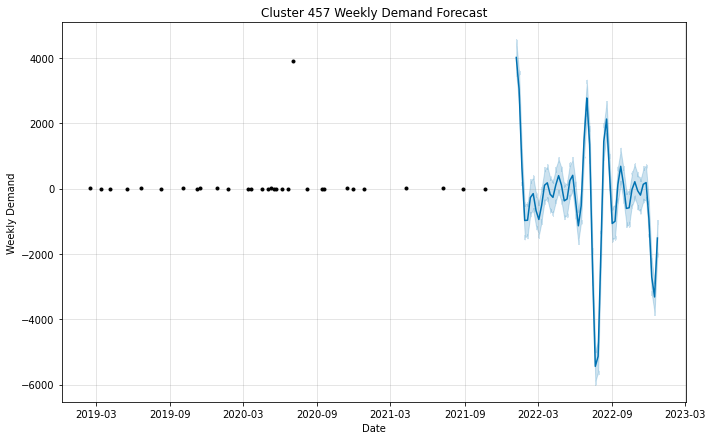

In [0]:


# Plot the forecast for the current cluster
fig = prophet_models[cluster].plot(forecast)
plt.title(f'Cluster {cluster} Weekly Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Demand')
plt.show()

In [0]:
print(predictions_df)

      CLUSTER_PRED DATE WEEKLY_DEMAND          yhat         ds
0                0  NaN          None  1.092036e+06 2022-01-07
1                0  NaN          None  1.092036e+06 2022-01-07
2                0  NaN          None  1.092036e+06 2022-01-07
3                0  NaN          None  1.092036e+06 2022-01-07
4                0  NaN          None  1.092036e+06 2022-01-07
...            ...  ...           ...           ...        ...
16016          457  NaN          None -1.512650e+03 2022-12-23
16017          457  NaN          None -1.512650e+03 2022-12-23
16018          457  NaN          None -1.512650e+03 2022-12-23
16019          457  NaN          None -1.512650e+03 2022-12-23
16020          457  NaN          None -1.512650e+03 2022-12-23

[7321597 rows x 5 columns]


In [0]:
# Get unique cluster values
cluster_values = train_pd['CLUSTER_PRED'].unique()

# Create an empty dictionary to store the Prophet models
prophet_models = {}

# Loop over each cluster value
for cluster in cluster_values:
    # Filter the dataframe to include only rows for the current cluster
    cluster_df = train_pd[train_pd['CLUSTER_PRED'] == cluster]

    # Remove ds values that contain '2022' in the column 'ds'
    mask = ~cluster_df['ds'].astype(str).str.contains('2022')
    cluster_df = cluster_df.loc[mask]
    
    # Rename the columns to match Prophet's input requirements
    cluster_df = cluster_df.rename(columns={'DATE': 'ds', 'WEEKLY_DEMAND': 'y'})
    
    # Create a new Prophet model using the filtered data
    m = Prophet()
    m.fit(cluster_df[['ds', 'y']])
    
    # Add the model to the dictionary with the cluster value as the key
    prophet_models[cluster] = m

# Create an empty dataframe to store the predictions
predictions_df = pd.DataFrame(columns=['CLUSTER_PRED', 'DATE', 'WEEKLY_DEMAND', 'yhat'])

# Loop over each cluster value and make predictions for the next 52 weeks
for cluster in cluster_values:
    # Use the corresponding Prophet model to make predictions for the future dates
    # future_dates = pd.date_range(start='2022-01-01', periods=52, freq='W')
    # future_df = pd.DataFrame({'ds': future_dates})
    forecast = prophet_models[cluster].predict(test_pd)
    
    # Add the predictions to the dataframe
    forecast['CLUSTER_PRED'] = cluster
    forecast['WEEKLY_DEMAND'] = None
    predictions_df = pd.concat([predictions_df, forecast[['CLUSTER_PRED', 'ds', 'WEEKLY_DEMAND', 'yhat']]])

# Print the predictions
print(predictions_df)


06:01:33 - cmdstanpy - INFO - Chain [1] start processing
06:01:33 - cmdstanpy - INFO - Chain [1] done processing
06:01:33 - cmdstanpy - INFO - Chain [1] start processing
06:01:33 - cmdstanpy - INFO - Chain [1] done processing
06:01:33 - cmdstanpy - INFO - Chain [1] start processing
06:01:33 - cmdstanpy - INFO - Chain [1] done processing
06:01:33 - cmdstanpy - INFO - Chain [1] start processing
06:01:33 - cmdstanpy - INFO - Chain [1] done processing
06:01:33 - cmdstanpy - INFO - Chain [1] start processing
06:01:34 - cmdstanpy - INFO - Chain [1] done processing
06:01:34 - cmdstanpy - INFO - Chain [1] start processing
06:01:34 - cmdstanpy - INFO - Chain [1] done processing
06:01:34 - cmdstanpy - INFO - Chain [1] start processing
06:01:34 - cmdstanpy - INFO - Chain [1] done processing
06:01:34 - cmdstanpy - INFO - Chain [1] start processing
06:01:34 - cmdstanpy - INFO - Chain [1] done processing
06:01:35 - cmdstanpy - INFO - Chain [1] start processing
06:01:35 - cmdstanpy - INFO - Chain [1]

In [0]:
def check_non_nan_rows(train_pd, cluster):
    """
    Checks the number of non-NaN rows in the given cluster of the DataFrame.

    Parameters:
    train_pd (pandas.DataFrame): The DataFrame to check.
    cluster (int): The cluster to check.

    Returns:
    bool: True if the cluster has 2 or more non-NaN rows, False otherwise.
    """
    cluster_df = train_pd[train_pd['CLUSTER_PRED'] == cluster]
    non_nan_count = cluster_df.notna().sum().sum()
    return non_nan_count >= 2


# Get unique cluster values
cluster_values = train_pd['CLUSTER_PRED'].unique()

# Loop over each cluster value and check the number of non-NaN rows
for cluster in cluster_values:
    if not check_non_nan_rows(train_pd, cluster):
        print(f"Cluster {cluster} has less than 2 non-NaN rows.")


In [0]:
# Group the predictions by cluster and sort by cluster ID
cluster_groups = predictions_df.groupby('CLUSTER_PRED').apply(lambda x: x.sort_values('ds'))

# Print the predictions for each cluster
for cluster, group in cluster_groups.groupby('CLUSTER_PRED'):
    print(f'Cluster {cluster} predictions:')
    print(group[['ds', 'yhat']])
    print('\n')


Cluster 11 predictions:
           ds       yhat
0  2022-01-02  10.095988
1  2022-01-09  13.197838
2  2022-01-16   7.599816
3  2022-01-23  -1.832251
4  2022-01-30  -6.338424
5  2022-02-06  -3.263887
6  2022-02-13   1.607978
7  2022-02-20   1.874409
8  2022-02-27  -1.571399
9  2022-03-06  -2.301514
10 2022-03-13     2.8869
11 2022-03-20    9.55021
12 2022-03-27  10.947292
13 2022-04-03   6.079069
14 2022-04-10    0.31289
15 2022-04-17   -1.59325
16 2022-04-24  -0.644812
17 2022-05-01  -0.627261
18 2022-05-08  -1.896026
19 2022-05-15  -0.971118
20 2022-05-22   3.521741
21 2022-05-29   7.451149
22 2022-06-05   6.269023
23 2022-06-12   2.484645
24 2022-06-19   4.557733
25 2022-06-26  16.431962
26 2022-07-03  30.063221
27 2022-07-10  31.809212
28 2022-07-17  17.382514
29 2022-07-24  -1.584577
30 2022-07-31    -8.1886
31 2022-08-07   2.606684
32 2022-08-14  19.073188
33 2022-08-21  25.320823
34 2022-08-28  17.208595
35 2022-09-04   4.499759
36 2022-09-11  -1.419917
37 2022-09-18   0.855768
3

In [0]:
# Get unique cluster values
cluster_values = train_pd['CLUSTER_PRED'].unique()

# Create an empty dictionary to store the Prophet models
prophet_models = {}

# Loop over each cluster value
for cluster in cluster_values[0:1]:
    # Filter the dataframe to include only rows for the current cluster
    cluster_df = train_pd[train_pd['CLUSTER_PRED'] == cluster]
    
    # Rename the columns to match Prophet's input requirements
    cluster_df = cluster_df.rename(columns={'DATE': 'ds', 'WEEKLY_DEMAND': 'y'})
    
    # Create a new Prophet model using the filtered data
    m = Prophet()
    m.fit(cluster_df[['ds', 'y']])
    
    # Add the model to the dictionary with the cluster value as the key
    prophet_models[cluster] = m

# Create a new dataframe with future dates
future_dates = pd.date_range(start='2022-01-01', periods=52, freq='W')

# Create an empty dataframe to store the predictions
predictions_df = pd.DataFrame(columns=['CLUSTER_PRED', 'ds', 'y'])

# Loop over each cluster value and make predictions for the next 30 days
for cluster in cluster_values[0:1]:
    # Use the corresponding Prophet model to make predictions for the future dates
    future_df = pd.DataFrame({'ds': future_dates})
    forecast = prophet_models[cluster].predict(future_df)
    
    # Add the predictions to the dataframe
    forecast['CLUSTER_PRED'] = cluster
    predictions_df = pd.concat([predictions_df, forecast[['CLUSTER_PRED', 'ds', 'yhat']]])

# Rename columns to match original dataframe
predictions_df.columns = ['CLUSTER_PRED', 'DATE', 'WEEKLY_DEMAND', 'yhat']

# Print the predictions
print(predictions_df)



22:17:26 - cmdstanpy - INFO - Chain [1] start processing
22:17:26 - cmdstanpy - INFO - Chain [1] done processing
   CLUSTER_PRED                 DATE WEEKLY_DEMAND          yhat
0             0  2022-01-02 00:00:00           NaN  1.252377e+06
1             0  2022-01-09 00:00:00           NaN  1.072968e+06
2             0  2022-01-16 00:00:00           NaN  1.067456e+06
3             0  2022-01-23 00:00:00           NaN  1.198145e+06
4             0  2022-01-30 00:00:00           NaN  1.292623e+06
5             0  2022-02-06 00:00:00           NaN  1.241692e+06
6             0  2022-02-13 00:00:00           NaN  1.106533e+06
7             0  2022-02-20 00:00:00           NaN  1.028353e+06
8             0  2022-02-27 00:00:00           NaN  1.067858e+06
9             0  2022-03-06 00:00:00           NaN  1.161912e+06
10            0  2022-03-13 00:00:00           NaN  1.220648e+06
11            0  2022-03-20 00:00:00           NaN  1.223633e+06
12            0  2022-03-27 00:00:00      

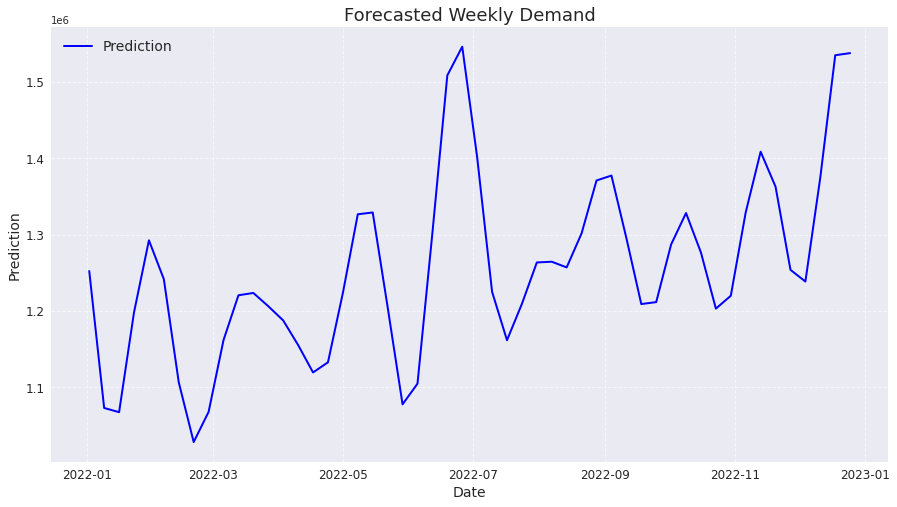

In [0]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Set the plot style to "seaborn"
plt.style.use("seaborn")

# Create a figure and axis objects
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the data
ax.plot(predictions_df["DATE"], predictions_df["yhat"], color="blue", linewidth=2)

# Set the axis labels and plot title
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Prediction", fontsize=14)
ax.set_title("Forecasted Weekly Demand", fontsize=18)

# Set the tick labels font size and format
ax.tick_params(labelsize=12)
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

# Set the grid lines and legend
ax.grid(linestyle="dashed", alpha=0.6)
ax.legend(["Prediction"], fontsize=14)

# Show the plot
plt.show()

In [0]:
# Define function to train a forecasting model for a single cluster
def train_model(cluster_df):
    # Implement your forecasting model training code here
    return forecasting_model

# Group the original dataframe by cluster ID
cluster_groups = df.groupBy("cluster_id")

# Apply the train_model function to each group in parallel using the map function
cluster_models = cluster_groups.map(lambda x: (x[0], train_model(x[1]))).collect()

# cluster_models is now a list of (cluster_id, forecasting_model) tuples


In [0]:
def train_and_forecast(group):
  # Initiate the model
  m = Prophet()
  
  # Fit the model
  m.fit(group)
  # Make predictions
  future = m.make_future_dataframe(periods=365)
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['CLUSTER_PRED'] = group['CLUSTER_PRED'].iloc[0]
  
  # Return the forecasted results
  return forecast[['ds', 'CLUSTER_PRED', 'yhat', 'yhat_upper', 'yhat_lower']]

In [0]:
def train_and_forecast(group):
  # Initiate the model
  m = Prophet()
  
  # Fit the model
  m.fit(group)
  # Make predictions
  future = m.make_future_dataframe(periods=375)
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['CLUSTER_PRED'] = group['CLUSTER_PRED'].iloc[0]
  
  # Return the forecasted results
  return forecast[['ds', 'CLUSTER_PRED', 'yhat', 'yhat_upper', 'yhat_lower']]



In [0]:
# Create an empty list to store the unique clusters
CLUSTER_PRED_list = []

# Loop over the unique values in the 'CLUSTER_PRED' column of your dataframe
for cluster in pd_df_458_00['CLUSTER_PRED'].unique():
    # Append the cluster value to the list
    CLUSTER_PRED_list.append(cluster)

# Print the list of unique clusters
print(CLUSTER_PRED_list)



[4, 436, 426, 430, 20, 50, 130, 340, 321, 43, 84, 0, 270, 24, 422, 397, 395, 14, 38, 249, 45, 310, 437, 272, 199, 418, 226, 364, 302, 336, 149, 175, 153, 307, 209, 445, 174, 427, 22, 214, 137, 52, 285, 202, 221, 343, 261, 187, 298, 323, 194, 114, 237, 444, 402, 368, 239, 373, 407, 338, 315, 222, 80, 101, 76, 160, 294, 328, 51, 440, 191, 246, 305, 48, 371, 450, 267, 375, 177, 279, 169, 152, 216, 335, 67, 377, 421, 252, 354, 435, 71, 72, 42, 121, 17, 243, 357, 333, 389, 25, 18, 138, 102, 219, 273, 300, 380, 367, 274, 312, 318, 349, 411, 12, 268, 365, 164, 11, 360, 34, 325, 330, 207, 329, 31, 451, 433, 287, 49, 359, 95, 234, 379, 173, 97, 180, 85, 82, 69, 30, 122, 352, 70, 64, 100, 245, 127, 242, 162, 108, 90, 443, 262, 417, 254, 447, 297, 383, 81, 378, 337, 382, 258, 136, 406, 55, 205, 317, 263, 344, 118, 281, 213, 413, 104, 39, 356, 251, 424, 388, 185, 27, 201, 452, 301, 284, 168, 306, 410, 9, 192, 303, 233, 75, 347, 224, 381, 316, 404, 247, 167, 161, 278, 415, 1, 295, 146, 86, 215, 248

GOING TO BE USING MEAN SQUARED ERROR (MSE), MEAN ABSOLUTE ERROR (MBE), MEAN ABSOLUTE PERCENTAGE ERROR (MAPE)

In [0]:
# MEAN SQUARED ERROR 

np.sqrt(mean_squared_error(y_true=test_data['y value'], 
                                y_pred = ltf_test_forecast['yhat']))

In [0]:
# MEAN ABSOLUTE ERROR

mean_absolute_error(y_true=test_data['y value'], 
                                y_pred = ltf_test_forecast['yhat']))

In [0]:
# MEAN ABSOLUTE PERCENTAGE ERROR (MAPE)

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=test_data['y value'], 
                                y_pred = ltf_test_forecast['yhat']))